In [109]:
import os
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import motornet as mn
import utils
import agents
import buffer
import task
import networks
import plot
from importlib import reload
reload(agents)
reload(utils)
reload(task)
reload(plot)
reload(buffer)
reload(networks)
from utils import load_env, load_policy, calc_loss, run_rollout, plot_simulations2, plot_rewards
from task import CentreOutFF, CentreOutFFGym
from agents import SLAgent, GRUPPOAgent
from stable_baselines3.common.vec_env import DummyVecEnv
# from plot import plot_simulations

from pathlib import Path
from sklearn.decomposition import PCA

# from sb3_contrib import RecurrentPPO


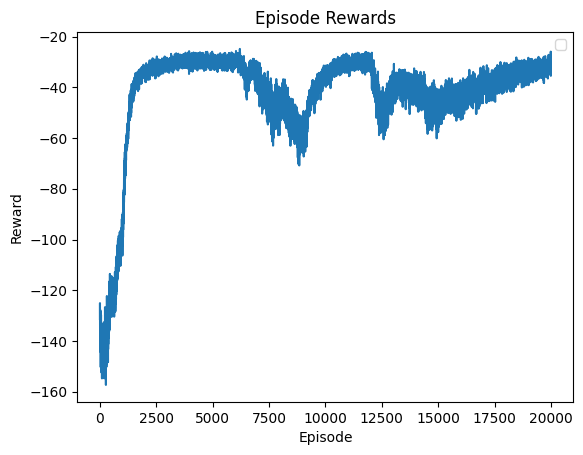

In [119]:
plot_rewards('./results/gruppo_agent9/episode_rewards.json')

Using device: cuda


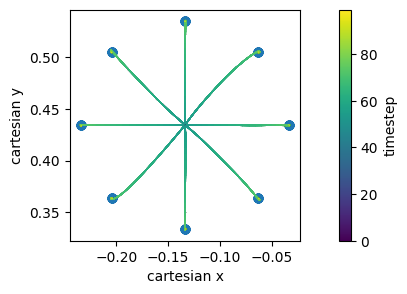

In [111]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
config = 'params.json'
print(f"Using device: {device}")
with open(config, 'r') as f:
    config = json.load(f)

# --- parameters setting ---
env_params = config['env_params']
train_params = config['training_params']
effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())
env = CentreOutFF(effector=effector, **env_params)
agentSL = SLAgent(17, 6)
agentSL.load('./results/adapt2_/agent_3000.pth')
# agent.load('./results/gruppo_agent7/agent_epi4000.pth')
# agent.load('./results/gruppo_agent8/agent_epi1800.pth')
# agent.load('./results/gruppo_agent9/agent_epi20000.pth')

data = run_rollout(env, agentSL, batch_size = 256, condition='test',ff_coefficient = 8., catch_trial_perc=0)
# fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations2(data)

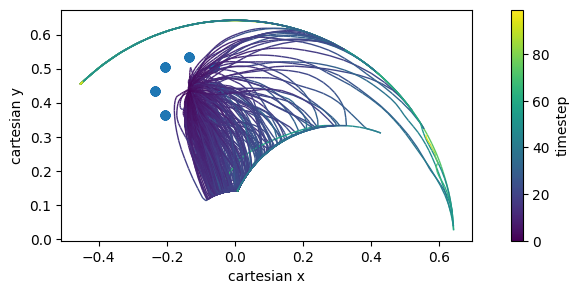

In [ ]:

agent = GRUPPOAgent(envRL, hidden_dim=128,  lr=5e-4, device=device)
# agent.load('./results/gruppo_agent9/agent_epi20000.pth')
agent.load('./results/gruppo_agent10/agent_epi20.pth')
data = run_rollout(envRL, agent, batch_size = 256, condition='test',ff_coefficient = 8., catch_trial_perc=0)
plot_simulations2(data)

In [134]:
cost_control, action

(tensor([5.1031e-10], grad_fn=<MulBackward0>),
 tensor([[0.0018, 0.0006, 0.0024, 0.0014, 0.0016, 0.0002]],
        grad_fn=<SqueezeBackward1>))

In [133]:
control_term = th.sum(100*action * (envRL.f_vec / envRL.f_norm_sq), dim=1)
cost_control = 0.03 * th.square(control_term)

In [122]:
current_pos = envRL.states['fingertip'][:, :2]
distance = th.linalg.norm(current_pos - envRL.goal, ord=1, dim=1) # L1 Norm


In [112]:
obs, info = env.reset()
h = agentSL.network.init_hidden(batch_size = 1)
action, h = agentSL.network(obs,h)
print(action)
env.step(action)
print(env.states['muscle'][0,0,:])

tensor([[0.0018, 0.0006, 0.0024, 0.0014, 0.0016, 0.0002]],
       grad_fn=<SqueezeBackward1>)
tensor([0.0020, 0.0010, 0.0028, 0.0015, 0.0017, 0.0010],
       grad_fn=<SliceBackward0>)


In [113]:
env.effector

RigidTendonArm26(
  (skeleton): TwoDofArm()
  (muscle): RigidTendonHillMuscle()
)

In [118]:
envRL.f_vec

tensor([1000., 1000., 1000., 1000., 1000., 1000.])

In [116]:
envRL = CentreOutFFGym(effector=effector, **env_params)
envRL.reset(options={'batch_size': 10}, catch_trial_perc=0)
env = CentreOutFF(effector=effector, **env_params)
env.reset(options={'batch_size': 10}, catch_trial_perc=0)


(tensor([[-0.0084,  0.6052,  0.9118,  1.1144,  1.1144,  0.6934,  0.9165,  0.7137,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4733,  0.4289,
           0.0000],
         [-0.1159,  0.4261,  0.9672,  1.0614,  0.8756,  0.8961,  0.7695,  0.8237,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4570,  0.3283,
           0.0000],
         [ 0.4045,  0.4314,  1.0975,  0.9366,  1.0885,  0.7214,  1.0768,  0.5416,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.3094,  0.1036,
           0.0000],
         [-0.0505,  0.5620,  0.9317,  1.0954,  1.0436,  0.7656,  0.8772,  0.7538,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1005,  0.6280,
           0.0000],
         [-0.3656,  0.5266,  0.7126,  1.3051,  1.2209,  0.5505,  0.8071,  0.8003,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.3311,  0.0788,
           0.0000],
         [-0.3145,  0.4426,  0.8289,  1.1938,  1.0114,  0.7943,  0.7497,  0.8863

In [ ]:
envRL.states['muscle']

NameError: name 'envRL' is not defined

In [ ]:
envRL.states['muscle'].stat_name

NameError: name 'envRL' is not defined

In [25]:
envRL.go_cue_time

array([0.10148135, 0.20490196, 1.        , 0.26313387, 1.        ,
       0.22721427, 1.        , 0.1958764 , 1.        , 1.        ])

In [5]:


# ======================================================================================
# 메인 분석 스크립트
# ======================================================================================
def analyze_hidden_states(hidden_states_data):
    """
    주어진 hidden state 데이터의 주성분 궤적을 분석하고 시각화합니다.

    Args:
        hidden_states_data (np.ndarray): 분석할 은닉 상태 데이터. 
                                         형태: (batch_size, time_steps, hidden_dims)
    """
    print("은닉 상태 분석 시작...")
    
    # 1. 데이터 형태 확인
    if hidden_states_data.ndim != 3:
        raise ValueError("입력 데이터는 반드시 (batch_size, time_steps, hidden_dims) 형태의 3차원 배열이어야 합니다.")
    
    batch_size, time_steps, hidden_dims = hidden_states_data.shape
    print(f"데이터 형태 확인: Batch={batch_size}, Time Steps={time_steps}, Hidden Dims={hidden_dims}")

    # 2. 데이터 처리 및 PCA
    # PCA를 위해 데이터를 (batch * steps, hidden_dims) 형태로 변환해야 합니다.
    # 올바른 궤적을 위해 (batch, steps, dims) -> (steps, batch, dims)로 축을 바꾼 뒤 reshape합니다.
    reshaped_states = hidden_states_data.transpose(1, 0, 2).reshape(-1, hidden_dims)
    
    print(f"PCA 수행 대상 데이터 형태: {reshaped_states.shape}")
    pca = PCA(n_components=2) # 상위 2개의 주성분 추출
    hidden_states_2d = pca.fit_transform(reshaped_states)
    
    print(f"설명된 분산 비율 (PC1, PC2): {pca.explained_variance_ratio_}")

    # 3. 시각화
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 각 배치의 궤적을 따로 그림
    for i in range(batch_size):
        # i번째 배치의 궤적 데이터 추출
        # Reshape된 데이터에서 i번째 배치의 데이터를 올바르게 가져옵니다.
        trajectory = hidden_states_2d[i::batch_size]
        
        # 시간에 따라 색상이 변하도록 컬러맵 설정 (파랑 -> 빨강)
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectory)))
        
        # 선분 하나씩 그리면서 색상 적용
        for j in range(len(trajectory) - 1):
            ax.plot(trajectory[j:j+2, 0], trajectory[j:j+2, 1], color=colors[j], alpha=0.6, linewidth=1.5)

    # 시작점과 끝점 표시
    start_points = hidden_states_2d[0:batch_size]
    end_points = hidden_states_2d[-batch_size:]
    ax.scatter(start_points[:, 0], start_points[:, 1], c='blue', s=100, label='Start (t=0)', zorder=3, ec='w')
    ax.scatter(end_points[:, 0], end_points[:, 1], c='red', s=100, label=f'End (t={time_steps-1})', zorder=3, ec='w')
    
    ax.set_title("GRU Hidden State Trajectory (PCA)", fontsize=16)
    ax.set_xlabel("Principal Component 1", fontsize=12)
    ax.set_ylabel("Principal Component 2", fontsize=12)
    ax.legend()
    ax.grid(True)
    plt.show()


PCA 수행 대상 데이터 형태: (25600, 128)
설명된 분산 비율 (PC1, PC2): [0.525959   0.20945957]


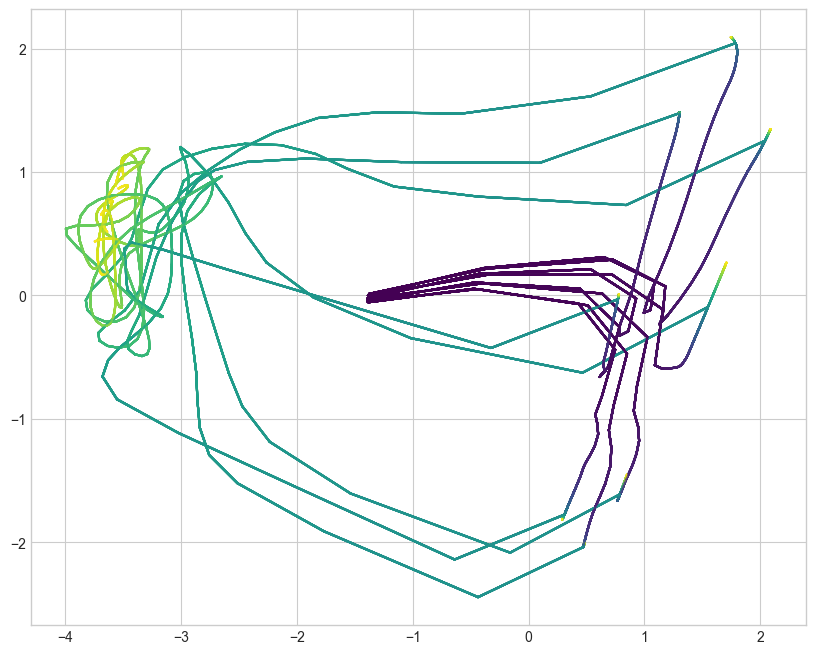

In [7]:
hidden_states_data = data['all_hidden'].detach().cpu().numpy()
batch_size, time_steps, hidden_dims = hidden_states_data.shape

reshaped_states = hidden_states_data.transpose(1, 0, 2).reshape(-1, hidden_dims)
    
print(f"PCA 수행 대상 데이터 형태: {reshaped_states.shape}")
pca = PCA(n_components=2) # 상위 2개의 주성분 추출
hidden_states_2d = pca.fit_transform(reshaped_states)

print(f"설명된 분산 비율 (PC1, PC2): {pca.explained_variance_ratio_}")

# 3. 시각화
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(batch_size):
# for i in range(4):
        # i번째 배치의 궤적 데이터 추출
        # Reshape된 데이터에서 i번째 배치의 데이터를 올바르게 가져옵니다.
        trajectory = hidden_states_2d[i::batch_size]
        
        # 시간에 따라 색상이 변하도록 컬러맵 설정 (파랑 -> 빨강)
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectory)))
        
        # 선분 하나씩 그리면서 색상 적용
        for j in range(len(trajectory) - 1):
            ax.plot(trajectory[j:j+2, 0], trajectory[j:j+2, 1], color=colors[j], alpha=0.6, linewidth=1.5)
            # ax.plot(trajectory[:, 0], trajectory[:, 1], color=colors[j], alpha=0.6, linewidth=1.5)


은닉 상태 분석 시작...
데이터 형태 확인: Batch=256, Time Steps=100, Hidden Dims=128
PCA 수행 대상 데이터 형태: (25600, 128)
설명된 분산 비율 (PC1, PC2): [0.525959   0.20945957]


/home/sungshinkim/anaconda3/envs/motornet_sb3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


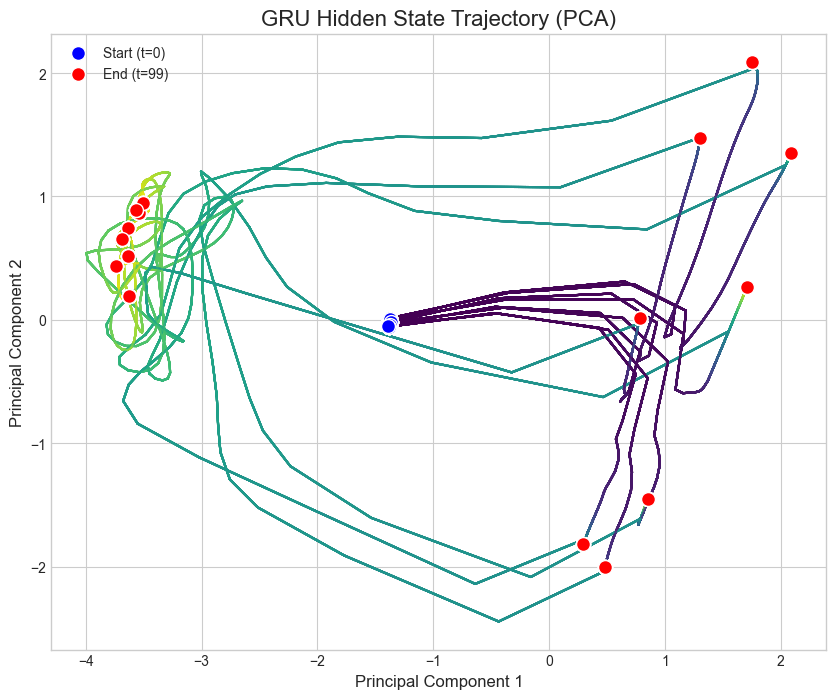

In [8]:
analyze_hidden_states(data['all_hidden'].detach().cpu().numpy())

In [16]:
np.random.uniform(0, 0.3, 128)

array([0.23861055, 0.07803752, 0.02844905, 0.1775125 , 0.21300433,
       0.27126263, 0.09833114, 0.24250578, 0.15470161, 0.15001588,
       0.09856777, 0.07094248, 0.18158786, 0.22849104, 0.1166019 ,
       0.26375664, 0.20795052, 0.23598157, 0.22885912, 0.19501195,
       0.08018636, 0.04109869, 0.18353429, 0.20256094, 0.11481288,
       0.01711302, 0.13980498, 0.06728261, 0.11442979, 0.07408842,
       0.13867965, 0.23642778, 0.24629385, 0.1112033 , 0.13462018,
       0.04079547, 0.01195745, 0.07691055, 0.28537998, 0.25398926,
       0.27984069, 0.14548995, 0.10380294, 0.14437687, 0.26666989,
       0.23445045, 0.12857878, 0.11857747, 0.08937139, 0.27661235,
       0.01281166, 0.25671696, 0.18242857, 0.07345264, 0.28278074,
       0.28155886, 0.1244745 , 0.02802578, 0.23801901, 0.12887089,
       0.25125846, 0.22971136, 0.01864898, 0.02403695, 0.22520639,
       0.25351056, 0.17394193, 0.12738844, 0.21826035, 0.11807257,
       0.13411198, 0.06853318, 0.10973533, 0.27094001, 0.22745

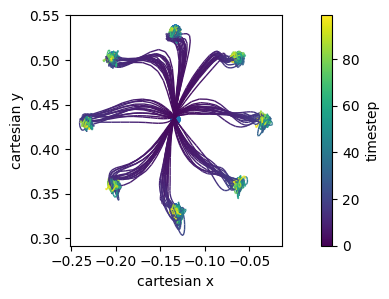

In [10]:
## Test the agent
device = 'cpu' # test model on CPU
env_gym = CentreOutFFGym(effector=effector, **env_params)

agent = GRUPPOAgent(env_gym)
# agent.load('./results/gruppo_agent7/agent_epi4000.pth')
# agent.load('./results/gruppo_agent8/agent_epi1800.pth')
agent.load('./results/gruppo_agent9/agent_epi20000.pth')

data = run_rollout(env_gym, agent, batch_size = 128, condition='test',ff_coefficient = 0.)


xy = data['xy'].detach().cpu().numpy()
tg = data['tg'].detach().cpu().numpy()
# fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations2(xy, tg)

In [29]:
from pathlib import Path
from buffer import RolloutBuffer
config = 'params.json'

with open(config, 'r') as f:
    config = json.load(f)

    # --- parameters setting ---
    env_params = config['env_params']
    train_params = config['training_params']

HIDDEN_DIM = 128
env = CentreOutFFGym(effector=effector, **env_params)


device = 'cuda' if th.cuda.is_available() else 'cpu'
agent = GRUPPOAgent(env, hidden_dim=HIDDEN_DIM, lr=5e-4, device=device)
load_path = Path('./results/gruppo_agent4/agent_epi18250.pth')
agent.load(load_path)

buffer = RolloutBuffer(env.observation_space.shape[0], env.action_space.shape[0], HIDDEN_DIM, train_params['batch_size'])
obs, _ = env.reset(options={'batch_size': train_params['batch_size']})
hidden_state = agent.network.init_hidden(train_params['batch_size'])

episode_rewards = []
current_episode_reward = 0
episode_idx = 0

for step in range(100):
        obs_tensor = th.from_numpy(obs).float().to(device)
        action, action_raw, value, log_prob, next_hidden_state = agent.select_action(obs_tensor, hidden_state)
        
        next_obs, reward, terminated, truncated, info = env.step(action)
        # print(terminated[0], step)
        buffer.add(obs, action_raw, action, reward, terminated, log_prob, value, hidden_state)
        current_episode_reward += float(np.mean(reward))
        
        obs = next_obs
        hidden_state = next_hidden_state



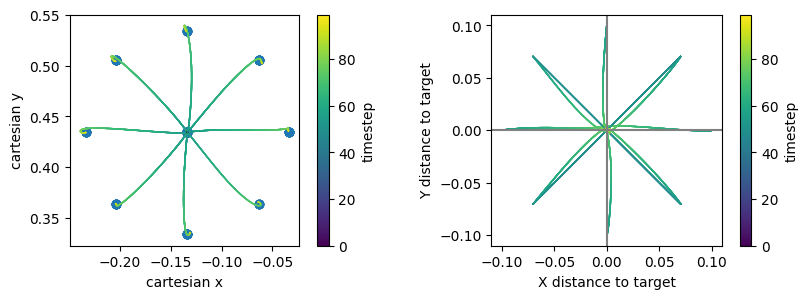

In [205]:
## Test the agent
device = 'cpu' # test model on CPU
agent = SLAgent(obs_dim=n_input, action_dim=n_output, device=device)
agent.load('./results/baseline_/agent_30000.pth')
data = run_rollout(env, agent, batch_size = 128, condition='test',ff_coefficient = 0.)
xy = data['xy'].detach().numpy() 
tg = data['tg'].detach().numpy()
# fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations2(xy, tg)

In [207]:
data['xy'].shape

torch.Size([128, 100, 2])

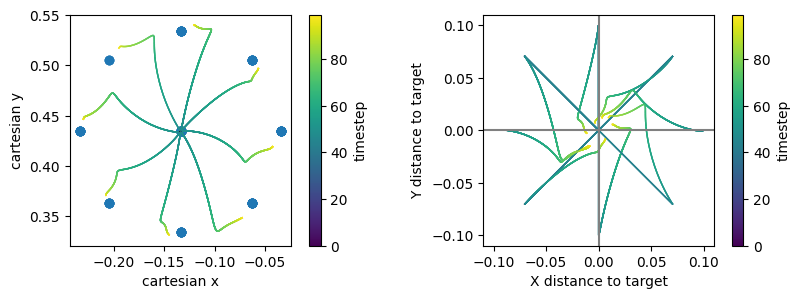

In [84]:
data = run_rollout(env, agent, batch_size = 128, condition='test',ff_coefficient = 8.)
xy = data['xy'].detach().numpy() 
tg = data['tg'].detach().numpy()
# fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations2(xy, tg)

In [9]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
import time

from stable_baselines3.common.env_checker import check_env


class RealTimeRewardCallback(BaseCallback):
    """
    매 에피소드가 끝날 때마다 터미널에 보상을 출력하는 콜백.
    """
    def __init__(self):
        super(RealTimeRewardCallback, self).__init__()
        self.episode_count = 0

    def _on_step(self) -> bool:
        # 에피소드가 종료되었는지 확인
        if self.locals['dones'][0]:
            self.episode_count += 1
            # 에피소드 정보에서 보상(reward)을 가져와 출력
            episode_reward = self.locals['infos'][0]['episode']['r']
            print(f"Episode: {self.episode_count}, Reward: {episode_reward:.2f}")
        return True

In [11]:
# [수정] 콜백 인스턴스 생성 (더 자주 체크)
realtime_callback = RealTimeRewardCallback()

# 환경을 4개 만들지만, DummyVecEnv는 이들을 단일 CPU에서 순차적으로 처리합니다.
num_envs = 4
env_vec = DummyVecEnv([lambda: Monitor(CentreOutFFGym(effector=effector, **env_params)) for _ in range(num_envs)])


# # Monitor로 환경을 감싼 뒤 DummyVecEnv에 전달합니다.
# # 병렬로 실행할 환경의 수 (보통 CPU 코어 수에 맞춰 설정)
# num_cpu = 4 

# # make_vec_env를 사용하면 병렬 환경을 쉽게 만들 수 있습니다.
# # env_id 대신 환경 클래스를 직접 전달할 수 있습니다.
# parallel_env = make_vec_env(
#     lambda: Monitor(CentreOutFFGym(effector=effector, **env_params)), 
#     n_envs=num_cpu, 
#     vec_env_cls=SubprocVecEnv  # 이 부분이 병렬 처리를 지정합니다.
# )
# # [수정] RecurrentPPO 모델 정의 시, 학습률과 훈련 스텝 수 조정
# TensorBoard 로그 디렉토리도 지정

RL_agent = RecurrentPPO(
    "MlpLstmPolicy", 
    env_vec, 
    verbose=0,
    learning_rate=2e-5,  # 학습률을 약간 낮춰 안정성 증가
    tensorboard_log = "./ppo_centreout/"
)

# [수정] 훈련 스텝 수를 대폭 증가
# total_training_steps = 200000
# start_time = time.time()
# model.learn(total_timesteps=total_training_steps, callback=realtime_callback, tb_log_name="CentreOutFF_RecurrentPPO")
# end_time = time.time()

# print(f"\n훈련 완료! (소요 시간: {end_time - start_time:.2f}초)")


In [ ]:
batch_size = 128
n_batch = 20000
losses = []
interval = 10
device = th.device("cuda" if th.cuda.is_available() else "cpu")
agent = SLAgent(obs_dim=n_input, action_dim=n_output, batch_size = batch_size, device=device)

for batch in range(n_batch):
    data = run_rollout(env, agent, batch_size=batch_size, device=device)
    loss = agent.update(data)
    losses.append(loss.item())

    if batch % interval == 0:
        avg = sum(losses[-interval:]) / len(losses[-interval:])  # Python float 평균
        print(f"Batch {batch}, Loss: {avg:.6f}")

Batch 0, Loss: 244.629013
Batch 10, Loss: 215.197780
Batch 20, Loss: 213.277055
Batch 30, Loss: 213.508365
Batch 40, Loss: 205.117561
Batch 50, Loss: 217.258887
Batch 60, Loss: 205.317537
Batch 70, Loss: 200.525197
Batch 80, Loss: 204.767581
Batch 90, Loss: 205.450362
Batch 100, Loss: 209.887082
Batch 110, Loss: 208.600537
Batch 120, Loss: 202.372105
Batch 130, Loss: 194.947829
Batch 140, Loss: 204.299207
Batch 150, Loss: 199.609152
Batch 160, Loss: 208.833443
Batch 170, Loss: 204.618181
Batch 180, Loss: 201.036871
Batch 190, Loss: 212.733647
Batch 200, Loss: 198.939685
Batch 210, Loss: 202.343854
Batch 220, Loss: 201.914203
Batch 230, Loss: 205.786514
Batch 240, Loss: 202.111743
Batch 250, Loss: 192.049518
Batch 260, Loss: 196.392998
Batch 270, Loss: 192.740025
Batch 280, Loss: 190.790805
Batch 290, Loss: 197.422760
Batch 300, Loss: 197.278680
Batch 310, Loss: 195.970227
Batch 320, Loss: 191.381975
Batch 330, Loss: 189.662456
Batch 340, Loss: 183.044022
Batch 350, Loss: 178.069807
Bat

In [ ]:
batch_size = 32
n_batch = 1000
losses = []
interval = 10

for batch in range(n_batch):
    data = run_episode(env, policy, batch_size=batch_size, ff_coefficient=0)
    overall_loss = calc_loss(data, loss_weight=None) # [1e+3,1e+5,1e-1,3e-4,1e-5,1e-3,0]
    # backward pass & update weights
    optimizer.zero_grad() 
    overall_loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()
    losses.append(overall_loss.item())

    if (batch % interval == 0) and (batch != 0):
        print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))



In [ ]:
batch_size = 32
n_batch = 1000
losses = []
interval = 10


def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

for batch in range(n_batch):
    h = policy.init_hidden(batch_size = batch_size)
    obs, info = env.reset(options={'batch_size':batch_size})
    terminated = False

    # initial poisitions and targets
    xy = [info["states"]["fingertip"][:, None, :]]
    tg = [info["goal"][:, None, :]]

    # simulate whole episode
    while not terminated:  # will run until `max_ep_duration` is reached
        action, h = policy(obs, h)
        obs, terminated, info = env.step(action=action)

        xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
        tg.append(info["goal"][:, None, :])  # targets

    # concatenate into a (batch_size, n_timesteps, xy) tensor
    xy = th.cat(xy, axis=1)
    tg = th.cat(tg, axis=1)
    # loss = calc_loss()
    loss = l1(xy, tg)

        # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()
    losses.append(loss.item())

    if (batch % interval == 0) and (batch != 0):
        print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))

    

Batch 10/1000 Done, mean policy loss: 0.22079749554395675
Batch 20/1000 Done, mean policy loss: 0.20228872448205948
Batch 30/1000 Done, mean policy loss: 0.1795849546790123
Batch 40/1000 Done, mean policy loss: 0.17905158698558807
Batch 50/1000 Done, mean policy loss: 0.18864884376525878
Batch 60/1000 Done, mean policy loss: 0.1743134081363678
Batch 70/1000 Done, mean policy loss: 0.16410528719425202
Batch 80/1000 Done, mean policy loss: 0.1467793956398964
Batch 90/1000 Done, mean policy loss: 0.15351783782243728
Batch 100/1000 Done, mean policy loss: 0.15058071538805962
Batch 110/1000 Done, mean policy loss: 0.13508556559681892
Batch 120/1000 Done, mean policy loss: 0.13054453805088997
Batch 130/1000 Done, mean policy loss: 0.1418978191912174
Batch 140/1000 Done, mean policy loss: 0.13029820770025252
Batch 150/1000 Done, mean policy loss: 0.125131693482399
Batch 160/1000 Done, mean policy loss: 0.12053677961230277
Batch 170/1000 Done, mean policy loss: 0.11072440147399902
Batch 180/10

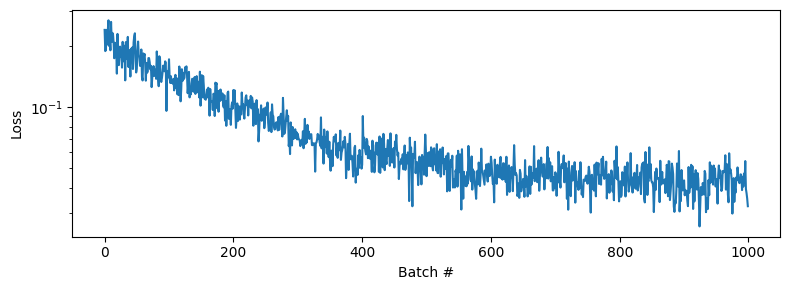

In [ ]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

In [ ]:
timestep = 0.01
muscle_name = 'RigidTendonHillMuscle'  # or 'HillMuscle'
muscle = getattr(mn.muscle,muscle_name)()
effector = mn.effector.RigidTendonArm26(muscle=muscle,timestep=timestep) 

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
# vectorized env 구성
# RecurrentPPO 모델 생성
# vec_env = DummyVecEnv([lambda: env])  # DummyVecEnv는 단일 환경을 벡터화하는 데 사용됩니다.
num_envs = 3
# vec_env = DummyVecEnv([lambda: SB3CentreOutFF(timestep=0.01, muscle_name='RigidTendonHillMuscle',
#                                               condition='train', is_channel=True) 
#                        for _ in range(num_envs)])
vec_env = DummyVecEnv([lambda: SB3CentreOutFF(timestep=0.01, muscle_name='RigidTendonHillMuscle', condition='train', is_channel=True ) for _ in range(num_envs)])

model = RecurrentPPO("MlpLstmPolicy", vec_env, verbose=1,
                    #  tensorboard_log="./sb3_recurrent_tensorboard/",
                     learning_rate=3e-4,
                     n_steps=128,    # on-policy rollout 길이. 환경 특성에 맞게 조정
                     batch_size=64,
                     n_epochs=10,
                     gamma=0.99,
                     clip_range=0.2)
model.learn(total_timesteps=200_000)
model.save("recurrent_ppo_centreout")
